title: AB test: remove explicit promo code step from signup flow
author: Fabio Schmidt-Fischbach   
date: 2020-06-16   
region: EU    
summary: Currently, users the the promo-code as a separate step of the signup flow. Only 20% of users enter a promo code and we lose 3-4% of users on the existing promo code step. The idea of this test was to remove this extra step and include the promo-code entry on the password step. % SUI to SU increases by 0.7pp. This is a great success. % users that use promo code goes down from 41% to 38.5%. % SU to KYCi and % KYCi to KYCc seems stable. Referral related CS contacts increase at very low level from 0.10% of users to 0.15% of users.
tags: signup, promo code, acquire, ab test   

In [2]:
import pandas as pd
import os
from statsmodels.stats.proportion import proportions_ztest
import altair as alt
from IPython.display import Image
import numpy as np

### 1. Setup 



Currently, users the the promo-code as a separate step of the signup flow as shown below. 

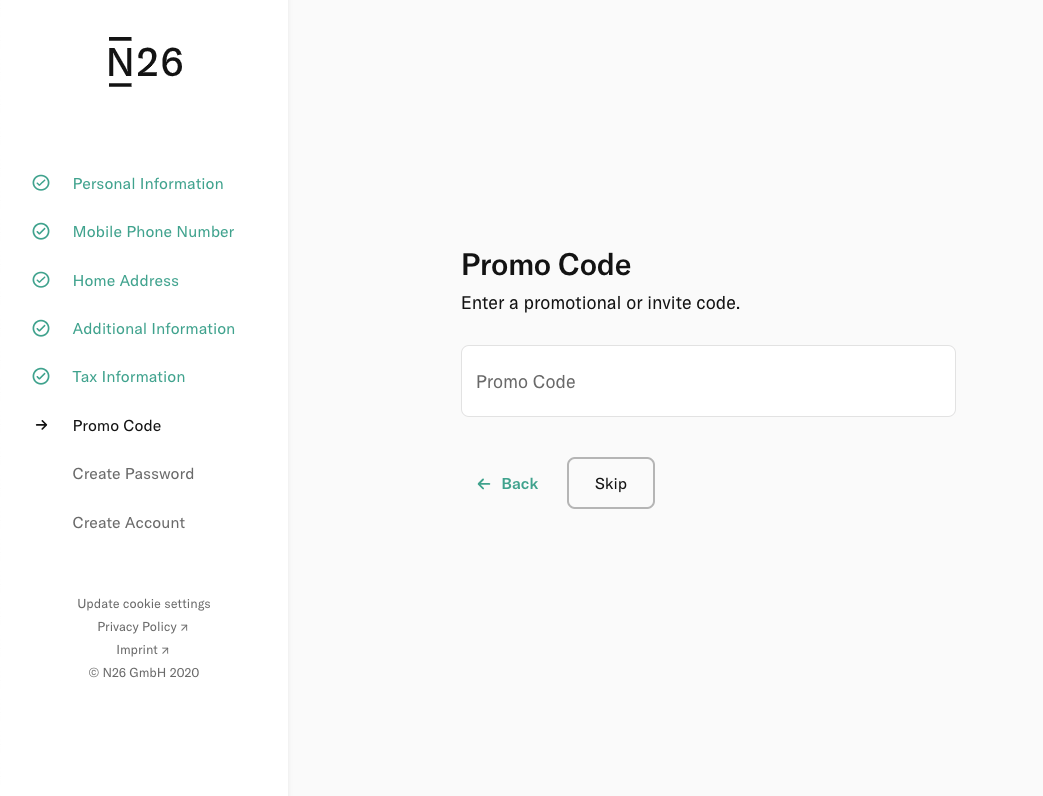

In [6]:
Image("control.png")

Only 20% of users enter a promo code and we lose 3-4% of users on the existing promo code step. The idea of this test was to remove this extra step and include the promo-code entry on the password step.  


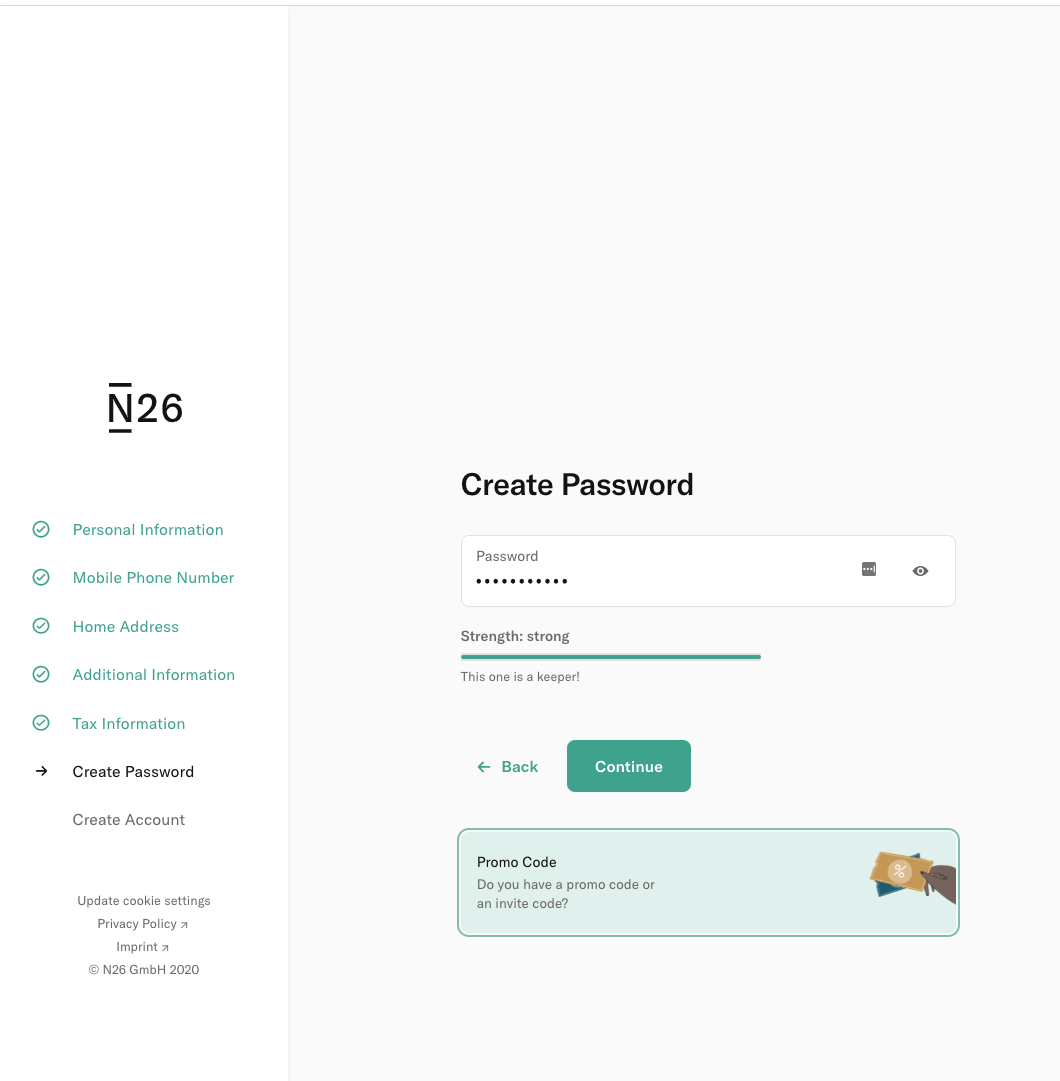

In [8]:
Image("variant.png")

### Exec summary 

- Better signup conversion: % SUI to SU increases by 0.7pp. This is a great success. 
- Fewer promo-code usage: % users that use promo code goes down from 41% to 38.5%.
- No apparent impact on lower funnel: % SU to KYCi and % KYCi to KYCc seems stable. 
- Referral related CS contacts increase at very low level from 0.10% of users to 0.15% of users. 


In [ ]:
query = """ 





-- get set of users that redeemed promo code or friend referral.
with promo as ( 


select distinct user_created  
from (

select distinct user_created 
from u_user_coupon 
where user_created >= '2020-06-05'


union 

select distinct user_created 
from u_referral  
where user_created>= '2020-06-05'

) as x 

)


SELECT  domain_userid, 
		shadow_user_id, 
		cmd.id as user_id,
		case when promo.user_created is not null then 1 else 0 end as promo, 
		step, 
		tbl.created, 
		country, 
		attribution, 
		os_family, 
		dvce_type, 
		webview, 
		se_property,
		kyc_first_initiated, 
		kyc_first_completed, 
		is_mau, 
		ref.status 
FROM dbt.stg_upper_funnel as tbl 
left join cmd_users as cmd on cmd.user_created = tbl.user_created 
left join promo on promo.user_created = tbl.user_created 
left join dbt.zrh_users as zu on zu.user_created = tbl.user_created 
left join u_referral as ref on ref.user_created = zu.user_created 
where tbl.created >= '2020-06-05' and se_property like 'promo_code_v2%'
    and coalesce(zu.user_created, current_date) >= tbl.created
"""

### 2. Analysis 

We start off by comparing the number of users entering each flow respectively. 

In our case, we have roughly 50k per variant giving us plenty of power to detect differences. 

In [52]:
df = pd.read_csv("promo_code.csv")

# get number of participants

df = df.loc[df["step"] == "signup-start", :]

# count unique users per variant.

df = df.groupby(["se_property"])["domain_userid"].agg("nunique").reset_index()


alt.Chart(df).mark_bar().encode(
    x=alt.X("se_property:N", axis=alt.Axis(title="Group")),
    y=alt.Y("domain_userid:Q", axis=alt.Axis(title="Number of users")),
).properties(title="Sample size", width=400, height=400).display(renderer="svg")

alt.Chart(...)

As a next step we compare the start to end conversion. SUI to SU conversion increases by 0.7pp. 

In [5]:
df = pd.read_csv("promo_code.csv")

df = df.loc[df["step"] == "signup-start", :]

df["su"] = 0
df.loc[df["user_id"].isna() == False, "su"] = 1

df = df.groupby(["se_property", "domain_userid"])["su"].agg("max").reset_index()
df = df.groupby(["se_property"])["su"].agg(["count", "sum"]).reset_index()


df["cr"] = 100 * df["sum"] / df["count"]

alt.Chart(df).mark_bar().encode(
    x=alt.X("se_property:N", axis=alt.Axis(title="Group")),
    y=alt.Y("cr:Q", axis=alt.Axis(title="% SUI to SU")),
).properties(title="% SUI to SU", width=400, height=400)

alt.Chart(...)

In [55]:
df.head()

,se_property,count,sum,cr
0,promo_code_v2,52591,19839,37.723185
1,promo_code_v2_control,52699,19526,37.051936


In [56]:
df = pd.read_csv("promo_code.csv")


df = df.loc[df["step"] == "signup-start", :]

df["su"] = 0
df.loc[df["user_id"].isna() == False, "su"] = 1


df = df.groupby(["se_property", "domain_userid"])["su"].agg("max").reset_index()

df = df.groupby(["se_property"])["su"].agg(["count", "sum"]).reset_index()

# run z test. (two sided)
stat, pval = proportions_ztest(df["sum"], df["count"])

print(
    "The z-score for this test is %s which corresponds to a p-value of %s"
    % (round(stat, 2), round(pval, 4))
)

if pval < 0.05:
    print("The difference is significant.")
else:
    print("The difference is not signficiant.")


# compute the effect size.
df["cr"] = df["sum"] / df["count"]

mu_v = df.loc[df["se_property"] == "promo_code_v2", "cr"][0]
mu_c = df.loc[df["se_property"] != "promo_code_v2", "cr"][1]
effect_size = 100 * ((mu_v - mu_c) / mu_c)

print("The effect size is %s Percent" % (round(effect_size, 2)))

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (2,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The z-score for this test is 2.25 which corresponds to a p-value of 0.0244
The difference is significant.
The effect size is 1.81 Percent


### 3. Impact on promo code usage. 

There is of course a risk that the new less prominent way of advertising promo-codes makes it harder for user to use them. 

We show the % of SU (sign up complete) that use a promo-code below: in the variant, promo-code usage drops by 2.5pp from 40.9% to 38.4%. 

In [6]:
df = pd.read_csv("promo_code.csv")

df = df.groupby(["user_id", "se_property"])["promo"].agg("max").reset_index()

# what % of users used a promo code?

df = df.groupby(["se_property"])["promo"].agg("mean").reset_index()

alt.Chart(df).mark_bar().encode(
    x=alt.X("se_property:N", axis=alt.Axis(title="Group")),
    y=alt.Y("promo:Q", axis=alt.Axis(title="% SU that uses promo code", format="%")),
).properties(title="% of users that use promo-code", width=400, height=400).display(
    renderer="svg"
)

alt.Chart(...)

In [7]:
df = pd.read_csv("promo_code.csv")

df = df.groupby(["user_id", "se_property"])["promo"].agg("max").reset_index()
# what % of users used a promo code?
df = df.groupby(["se_property"])["promo"].agg(["count", "sum"]).reset_index()


# run z test. (two sided)
stat, pval = proportions_ztest(df["sum"], df["count"])

print(
    "The z-score for this test is %s which corresponds to a p-value of %s"
    % (round(stat, 2), round(pval, 4))
)

if pval < 0.05:
    print("The difference is significant.")
else:
    print("The difference is not signficiant.")

# compute the effect size.
df["cr"] = df["sum"] / df["count"]

mu_v = df.loc[df["se_property"] == "promo_code_v2", "cr"][0]
mu_c = df.loc[df["se_property"] != "promo_code_v2", "cr"][1]
effect_size = 100 * ((mu_v - mu_c) / mu_c)

print("The effect size is %s Percent" % (round(effect_size, 2)))

The z-score for this test is -4.46 which corresponds to a p-value of 0.0
The difference is significant.
The effect size is -3.96 Percent


While the above pulled promo codes from both u_referral and u_user_coupon, the next one just focuses on friend referral promo codes. What % of SU have a friend referral code? 

In [3]:
df = pd.read_csv("promo_code.csv")

df["referral"] = 0
df.loc[df["status"].isna() == False, "referral"] = 1


df = df.groupby(["user_id", "se_property"])["referral"].agg("max").reset_index()

# what % of users used a promo code?

df = df.groupby(["se_property"])["referral"].agg("mean").reset_index()

alt.Chart(df).mark_bar().encode(
    x=alt.X("se_property:N", axis=alt.Axis(title="Group")),
    y=alt.Y(
        "referral:Q", axis=alt.Axis(title="% SU that use friend referral", format="%")
    ),
).properties(title="% of SU with friend referral", width=400, height=400).display(
    renderer="svg"
)

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (2,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


alt.Chart(...)

In [4]:
df.head()

,se_property,referral
0,promo_code_v2,0.175836
1,promo_code_v2_control,0.230733


### 4. Impact on lower funnel 

The next concern is that some users that overlook the new promo code field are frustrated and stop their onboarding journey. 

Since the test is quite recent, the best thing to look at is KYC initiated. % SU to KYCi indeed goes slightly down by 0.3pp. 

In [8]:
df = pd.read_csv("promo_code.csv")

df["kyci"] = 0
df.loc[df["kyc_first_initiated"].isna() == False, "kyci"] = 1

df = df.groupby(["se_property", "user_id"])["kyci"].agg("max").reset_index()
df = df.groupby(["se_property"])["kyci"].agg("mean").reset_index()

alt.Chart(df).mark_bar().encode(
    x=alt.X("se_property:N", axis=alt.Axis(title="Group")),
    y=alt.Y("kyci:Q", axis=alt.Axis(title="% SU that initiate KYC", format="%")),
).properties(title="% of SU that initiate KYC", width=400, height=400).display(
    renderer="svg"
)

alt.Chart(...)

In [61]:
df.head()

,se_property,kyci
0,promo_code_v2,0.698180
1,promo_code_v2_control,0.696776


And for completeness, we also look at % KYCi to KYCc conversions. Since the test started on 5th June 2020 and the analysis is done on the 15th, we can only do this analysis on a subset of the whole sample. We drop all users that KYCi in the last 7 days (e.g. on the 8th or later) and do this step only on users that joined before that.

The KYCi to KYCc conversion seems intact. 

In [9]:
from datetime import datetime, timedelta

df = pd.read_csv("promo_code.csv")
df["kycc"] = 0
df.loc[df["kyc_first_completed"].isna() == False, "kycc"] = 1

df = df.loc[
    pd.to_datetime(df["kyc_first_initiated"]) <= datetime.now() - timedelta(days=7), :
]

df = df.groupby(["se_property", "user_id"])["kycc"].agg("max").reset_index()
df = df.groupby(["se_property"])["kycc"].agg("mean").reset_index()

alt.Chart(df).mark_bar().encode(
    x=alt.X("se_property:N", axis=alt.Axis(title="Group")),
    y=alt.Y("kycc:Q", axis=alt.Axis(title="% KYCi to KYCc", format="%")),
).properties(title="% KYCi to KYC", width=400, height=400).display(renderer="svg")

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (2,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


alt.Chart(...)

In [63]:
df.head()

,se_property,kycc
0,promo_code_v2,0.770948
1,promo_code_v2_control,0.773648


In [10]:
df = pd.read_csv("promo_code.csv")

df["kyci"] = 0
df.loc[df["kyc_first_initiated"].isna() == False, "kyci"] = 1

df = df.groupby(["se_property", "promo", "user_id"])["kyci"].agg("max").reset_index()
df = (
    df.groupby(["se_property", "promo", "kyci"])["user_id"].agg("nunique").reset_index()
)

df["perc"] = (
    100
    * df["user_id"]
    / df.groupby(["promo", "se_property"])["user_id"].transform("sum")
)

alt.Chart(df).mark_bar().encode(
    x=alt.X("se_property:N", axis=alt.Axis(title="Group")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% SU that initiate KYC")),
    column="promo:N",
).properties(title="% of SU that initiate KYC", width=400, height=400).display(
    renderer="svg"
)

alt.Chart(...)

In [65]:
df.head(10)

,se_property,promo,kyci,user_id,perc
0,promo_code_v2,0,0,5209,58.626899
1,promo_code_v2,0,1,3676,41.373101
2,promo_code_v2,1,0,694,6.502389
3,promo_code_v2,1,1,9979,93.497611
4,promo_code_v2_control,0,0,4988,60.067437
5,promo_code_v2_control,0,1,3316,39.932563
6,promo_code_v2_control,1,0,843,7.715541
7,promo_code_v2_control,1,1,10083,92.284459


Finally, to conclude this part of the analysis let's look at % SUI that finish KYC. This shows that the feature in the end produces more KYCc than the control.

In [11]:
from datetime import datetime, timedelta

df = pd.read_csv("promo_code.csv")

df = df.loc[df["step"] == "signup-start", :]

df["kycc"] = 0
df.loc[df["kyc_first_completed"].isna() == False, "kycc"] = 1

df = df.groupby(["se_property", "domain_userid"])["kycc"].agg("max").reset_index()
df = df.groupby(["se_property"])["kycc"].agg("mean").reset_index()

alt.Chart(df).mark_bar().encode(
    x=alt.X("se_property:N", axis=alt.Axis(title="Group")),
    y=alt.Y("kycc:Q", axis=alt.Axis(title="% SUI that complete KYC", format="%")),
).properties(title="% of SUI that complete KYC", width=400, height=400).display(
    renderer="svg"
)

alt.Chart(...)

In [67]:
df.head()

,se_property,kycc
0,promo_code_v2,0.204389
1,promo_code_v2_control,0.201047


### 5. Impact on CS contacts 

I used the referral tagged cs cases to evaluate this. This might not capture all CS contacts that were actually about this topic - please treat this part of the analysis with caution. 

#### Results:  

While the treatment sees an increased rate (0.15% vs 0.10% of users), the level of this effect is not too concerning (34 contacts out of 22k users).

In [ ]:
query = """ 

-- get set of users that complained about referral to cs
with cs as ( 

select 
        user_id
from sf_contact
left join sf_case on sf_case.contact_id = sf_contact.id and sf_case.created_date >= '2020-06-05'
group by 1

)

SELECT  domain_userid, 
		shadow_user_id, 
		cmd.id as user_id,
		case when cs.user_id is not null then 1 else 0 end as cs, 
		step, 
		tbl.created, 
		country, 
		attribution, 
		os_family, 
		dvce_type, 
		webview, 
		se_property,
		kyc_first_initiated, 
		kyc_first_completed 
FROM dbt.stg_upper_funnel_tbl as tbl 
left join cmd_users as cmd on cmd.user_created = tbl.user_created 
left join cs on cs.user_id = cmd.id 
left join dbt.zrh_users as zu on zu.user_created = tbl.user_created 
where tbl.created >= '2020-06-05' and se_property like 'promo_code_v2%'



"""

In [48]:
df = pd.read_csv("promo_cs.csv")

df = df.groupby(["se_property", "user_id"])["cs"].agg("max").reset_index()

df = df.groupby(["se_property"])["cs"].agg("mean").reset_index()


alt.Chart(df).mark_bar().encode(
    x=alt.X("se_property:N", axis=alt.Axis(title="Group")),
    y=alt.Y("cs:Q", axis=alt.Axis(title="% SU contact CS about referral", format="%")),
).properties(title="% SU contact CS about referral", width=400, height=400).display(
    renderer="svg"
)

alt.Chart(...)

In [5]:
df = pd.read_csv("promo_cs.csv")

df = df.groupby(["se_property", "user_id"])["cs"].agg("max").reset_index()

df = df.groupby(["se_property"])["cs"].agg(["count", "sum"]).reset_index()

df.head()

,se_property,count,sum
0,promo_code_v2,22377,34
1,promo_code_v2_control,22015,23


### 6. Impact on activation

This part focuses on whether users that we push through the funnel also activate. The next chart shows that more % of SUI turn MAU in the variant than in the control. 

In [69]:
df = pd.read_csv("promo_code.csv")

df = df.loc[df["step"] == "signup-start", :]

df["mau"] = 0
df.loc[df["is_mau"] == True, "mau"] = 1

df = df.groupby(["se_property", "domain_userid"])["mau"].agg("max").reset_index()
df = df.groupby(["se_property"])["mau"].agg("mean").reset_index()

alt.Chart(df).mark_bar().encode(
    x=alt.X("se_property:N", axis=alt.Axis(title="Group")),
    y=alt.Y("mau:Q", axis=alt.Axis(title="% SUI that are now MAU", format="%")),
).properties(title="% SUI that are now MAU", width=400, height=400).display(
    renderer="svg"
)

/Users/fabioschmidt-fischbach/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (2,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


alt.Chart(...)

In [70]:
df.head()

,se_property,mau
0,promo_code_v2,0.123386
1,promo_code_v2_control,0.123000


The main difference in %SUI to MAU is driven by users that do not apply a friend referral promo code. Users with a friend referral promo code are slightly less likely to turn MAU.

The big level difference in % SUI to MAU across referral and non-referrals is explained by the much higher % SUI to SU conversion of friend referral traffic. 

In [72]:
df = pd.read_csv("promo_code.csv")

df = df.loc[df["step"] == "signup-start", :]

df["mau"] = 0
df.loc[df["is_mau"] == True, "mau"] = 1

df["referral"] = False
df.loc[df["status"].isna() == False, "referral"] = True

df = (
    df.groupby(["se_property", "referral", "domain_userid"])["mau"]
    .agg("max")
    .reset_index()
)
df = df.groupby(["se_property", "referral"])["mau"].agg("mean").reset_index()

alt.Chart(df).mark_bar().encode(
    x=alt.X("se_property:N", axis=alt.Axis(title="Group")),
    y=alt.Y("mau:Q", axis=alt.Axis(title="% SUI that are now MAU", format="%")),
    column="referral:N",
).properties(title="% SUI that are now MAU", width=400, height=400).display(
    renderer="svg"
)

alt.Chart(...)

In [73]:
df.head(10)

,se_property,referral,mau
0,promo_code_v2,False,0.102163
1,promo_code_v2,True,0.416525
2,promo_code_v2_control,False,0.094460
3,promo_code_v2_control,True,0.422111


In [12]:
df = pd.read_csv("promo_code.csv")

df = df.loc[df["step"] == "signup-start", :]

df = df.loc[(df["kyc_first_completed"].isna() == False), :]
df = df.loc[(df["status"].isna() == False), :]

df = df.groupby(["se_property", "status"])["user_id"].agg("nunique").reset_index()
df["perc"] = (
    100 * df["user_id"] / df.groupby(["se_property"])["user_id"].transform("sum")
)

alt.Chart(df).mark_bar().encode(
    x=alt.X("status:N", axis=alt.Axis(title="Group")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% status of friend referral KYCc")),
    column="se_property:N",
).properties(title="% status of friend referral KYCc", width=400, height=400).display(
    renderer="svg"
)

alt.Chart(...)

In [75]:
df.head(10)

,se_property,status,user_id,perc
0,promo_code_v2,MAX_PAYOUT_EXCEEDED_NO_REWARD,5,0.224921
1,promo_code_v2,PENDING,1595,71.749888
2,promo_code_v2,REWARDED,623,28.025191
3,promo_code_v2_control,MAX_PAYOUT_EXCEEDED_NO_REWARD,17,0.587828
4,promo_code_v2_control,PENDING,2026,70.055325
5,promo_code_v2_control,REWARDED,849,29.356846
